## About

In this notebook, I am trying to perform customer segmentation based on Recency, Frequency, Monetary Value Analysis (RFM Analysis) using data from an online store transactions.

I will use a clustering method using KMeans algorithm to cluster similar custmers in same groups.

At the end, I will deliver an interpertation of the results and analysis of segments.

#### Steps

- Importing and Exploring Dataset
- Customers Feature Extraction from data
- Preprocessing and Preparation for clustering
- Determining number of clusters
- Perform Clustering
- Show results and analysis of segements.

## About Dataset

This dataset represents transactions from a UK-based online retail store. [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail)

In [216]:
# import important packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [217]:
data = pd.read_csv("data/online_retail.csv")
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68176 entries, 0 to 68175
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   68176 non-null  int64  
 1   InvoiceNo    68176 non-null  int64  
 2   StockCode    68176 non-null  object 
 3   Description  68176 non-null  object 
 4   Quantity     68176 non-null  int64  
 5   InvoiceDate  68176 non-null  object 
 6   UnitPrice    68176 non-null  float64
 7   CustomerID   68176 non-null  int64  
 8   Country      68176 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 4.7+ MB


In [219]:
# check missing data
data.isna().sum()

Unnamed: 0     0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Preprocessing

In [220]:
# convert "InvoiceDate" column to datetime 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%Y-%m-%d")

### Descriptive Analysis

In [221]:
print("we have", data.shape[0], "Transactions for", data['CustomerID'].nunique(), "Customer in", data['Country'].unique()[0])
print("Transactions has been taken from", data['InvoiceDate'].min().strftime("%Y-%m-%d"), "to", data['InvoiceDate'].max().strftime("%Y-%m-%d"))

we have 68176 Transactions for 3643 Customer in United Kingdom
Transactions has been taken from 2010-12-10 to 2011-12-09


Text(0.5, 1.0, 'Distribution of "UnitPrice" attribute')

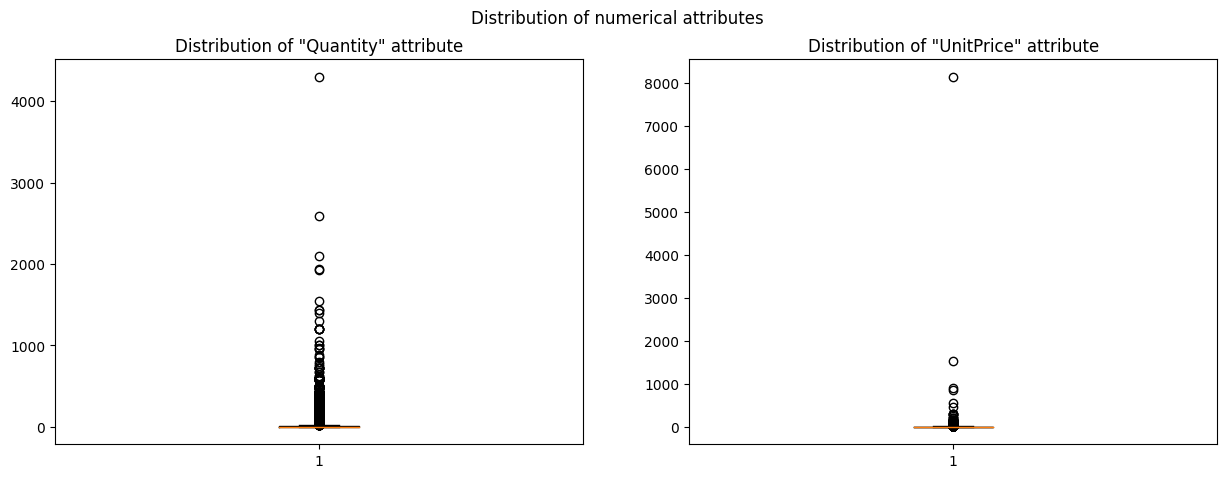

In [222]:
# Distribution of quantative data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Distribution of numerical attributes')

axes[0].boxplot(data['Quantity']);
axes[0].set_title("Distribution of \"Quantity\" attribute")

axes[1].boxplot(data['UnitPrice']);
axes[1].set_title("Distribution of \"UnitPrice\" attribute")

almost all data is concentrated at low values except for some outliers.

### Feature Engineering

try to extract features for each customer based on his behavior in the transactions dataset.

featrues will be correspond to RFM Analysis. This means that features will express Recency, Frequency and Monetary value for each customer.

- Recency : measure how recent each customer's last purchase.
- Frequency : measures how many purchases the customer has done.
- Monetary Value : measures how much has the customer spend.

We need to calculate how many days since the last purchase. To do this, we need a refrence day. So, i will create a hypothetical date and calculate based on it. that date will be the day after the last recent transaction in the dataset.

In [223]:
ref_day = data['InvoiceDate'].max() + datetime.timedelta(days=1)

In [224]:
# create total price column by multiplying quantity and unit price columns
data = data.assign(TotalPrice = data.Quantity * data.UnitPrice)

In [225]:
customers_rfm = data.groupby("CustomerID").agg({
    "InvoiceDate" : lambda x : (ref_day - x.max()).days,
    "InvoiceNo" : "count",
    "TotalPrice" : "sum"
}).rename(columns={"InvoiceDate" : "R", "InvoiceNo" : "F", "TotalPrice" : "M"})

In [226]:
# Display sample of customer RFM Characteristics dataframe
customers_rfm.head()

,R,F,M
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [227]:
# Display some discriptive statistics of customer RFM Characteristics
customers_rfm.describe().round(1)

,R,F,M
count,3643.0,3643.0,3643.0
mean,90.4,18.7,370.7
std,94.4,43.8,1347.4
min,1.0,1.0,0.6
25%,19.0,4.0,58.7
50%,51.0,9.0,136.4
75%,139.0,21.0,334.4
max,365.0,1497.0,48060.4


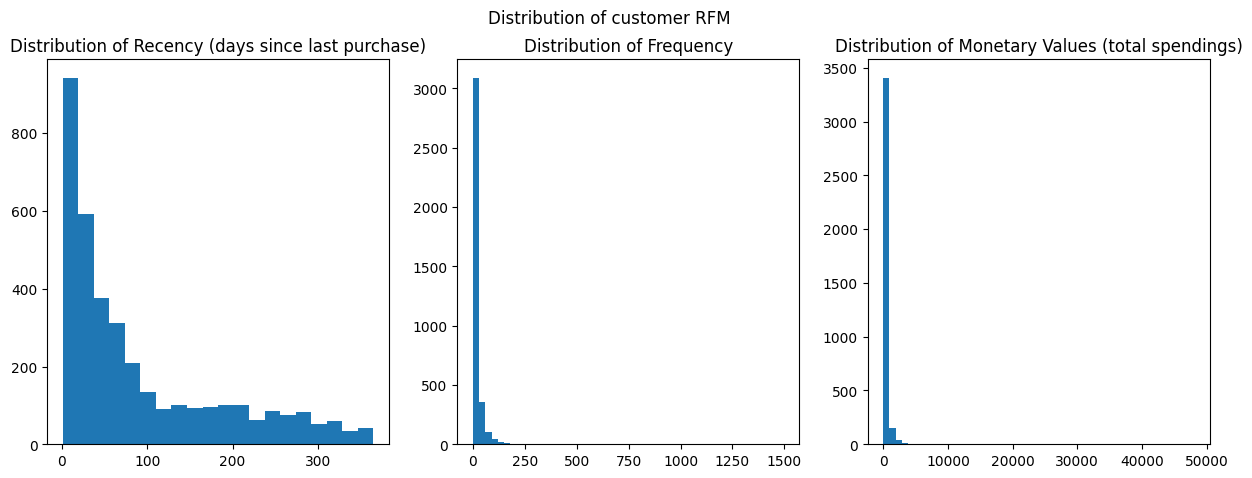

In [228]:
# Show the distribution of customer RFM Characteristics
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5));
fig.suptitle("Distribution of customer RFM");

axes[0].hist(customers_rfm['R'], bins=20);
axes[0].set_title("Distribution of Recency (days since last purchase)");

axes[1].hist(customers_rfm['F'], bins=50);
axes[1].set_title("Distribution of Frequency");

axes[2].hist(customers_rfm['M'], bins=50);
axes[2].set_title("Distribution of Monetary Values (total spendings)");

we can observe the skewness of data in the three RFM Values

### Data Preparation

After extracting the characteristics of customers behavior, we need to run a clustering algorithm (KMeans) to segment similar customers together.

But we need some data preparations before running KMeans for best results.

I am going to do the following:
- reduce data skewness to be more symmetrical --> using log transform as no negative data exist.
- scaling data to have same mean and standard deviation --> using sklearn StandardScaler

#### Log transform

In [229]:
# log transform
customers_rfm_log = np.log(customers_rfm)

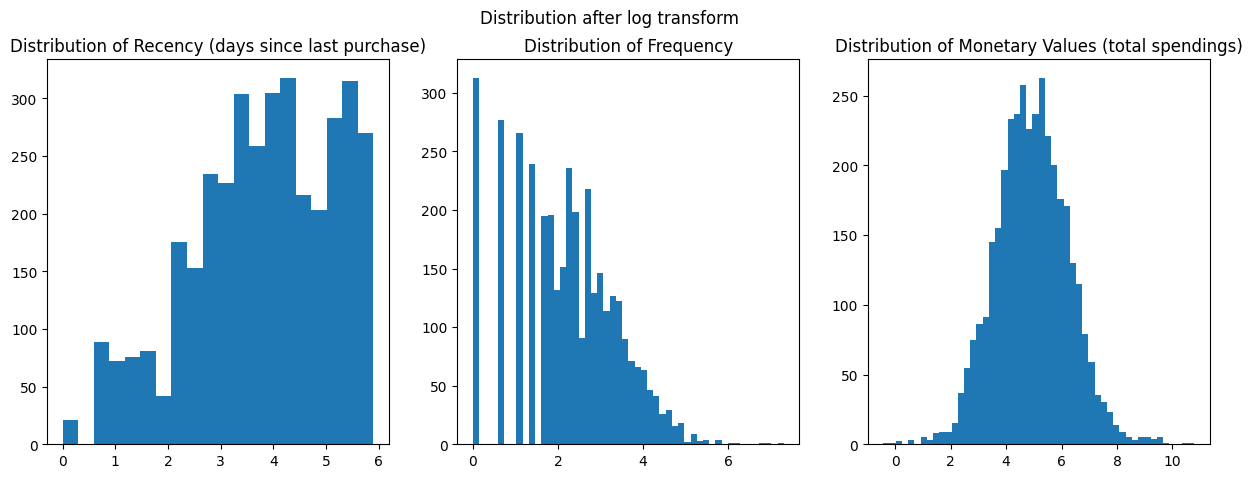

In [230]:
# Show the distribution after log transform
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5));
fig.suptitle("Distribution after log transform");

axes[0].hist(customers_rfm_log['R'], bins=20);
axes[0].set_title("Distribution of Recency (days since last purchase)");

axes[1].hist(customers_rfm_log['F'], bins=50);
axes[1].set_title("Distribution of Frequency");

axes[2].hist(customers_rfm_log['M'], bins=50);
axes[2].set_title("Distribution of Monetary Values (total spendings)");

#### Scaling using Standard Scalar

In [231]:
scaler = StandardScaler()
scaler.fit(customers_rfm_log)
customers_rfm_scaled = scaler.transform(customers_rfm_log).round(2)

customers_rfm_scaled = pd.DataFrame(customers_rfm_scaled, index=customers_rfm.index, columns=customers_rfm.columns)

,R,F,M
CustomerID,,,
12747,-2.00,0.87,1.46
12748,-2.81,3.82,2.99
12749,-1.79,1.19,1.35
12820,-1.79,0.55,0.50
12822,0.34,0.02,0.04
...,...,...,...
18280,1.35,-1.22,-0.98
18281,1.03,-1.22,-1.13
18282,-1.28,-1.22,-1.15


In [233]:
customers_rfm_scaled.describe().round(2)

,R,F,M
count,3643.00,3643.00,3643.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.81,-1.79,-4.09
25%,-0.64,-0.65,-0.66
50%,0.09,0.02,-0.01
75%,0.83,0.72,0.67
max,1.55,4.25,4.46


It is clear that data attributes have same mean and variance after transformations.

### KMeans Clustering